In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "/content/drive/My Drive/Malaria_images"

cell-images-for-detecting-malaria.zip  model_vgg_90.pt


In [0]:
!unzip -q "/content/drive/My Drive/Malaria_images/cell-images-for-detecting-malaria.zip"

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import torch
torch.manual_seed(0)
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

import os
print(os.listdir("cell_images"))

['Uninfected', 'Parasitized']


# New Section

In [0]:
train_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])

In [0]:
image_dir = "cell_images/"
train_set = datasets.ImageFolder(image_dir, transform=train_transforms)

In [0]:
test_size = 0.15
valid_size= 0.15

num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)

test_split = int(np.floor((test_size) * num_train))
valid_split = int(np.floor((valid_size) * num_train))
test_index, valid_index, train_index = indices[:test_split - 1], indices[test_split - 1:test_split+valid_split-1], indices[test_split+valid_split :]

train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
test_sampler = SubsetRandomSampler(test_index)

train_loader = DataLoader(train_set, sampler=train_sampler, batch_size=104)
valid_loader = DataLoader(train_set, sampler=valid_sampler, batch_size=58)
test_loader = DataLoader(train_set, sampler=test_sampler, batch_size=58)
print("Images in Test set: {}\nImages in Train set: {} \n Images in validation set {}".format(len(test_index), len(train_index), len(valid_index)))

Images in Test set: 4132
Images in Train set: 19292 
 Images in validation set 4133


In [0]:
classes=['infected','uninfected']

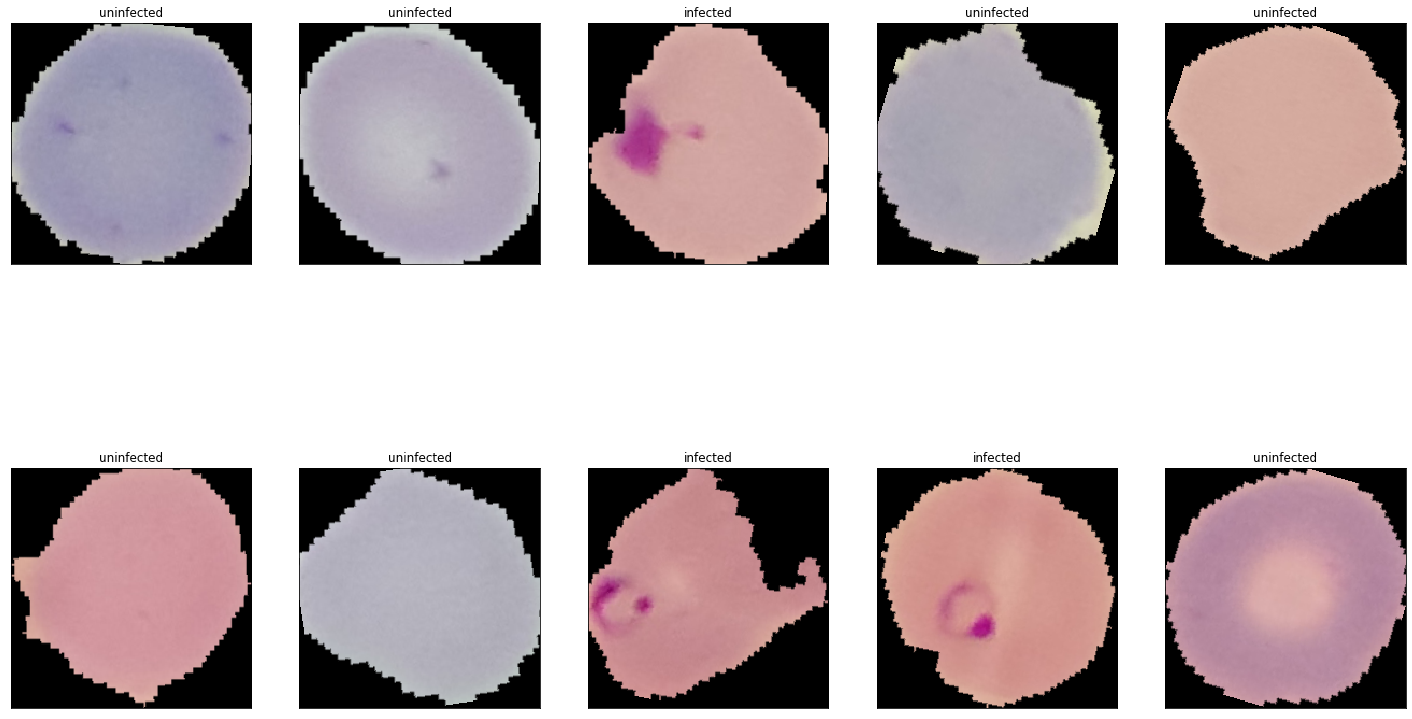

In [0]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(25, 15))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[], title=classes[labels[i]])
    imshow(images[i])
plt.show()

In [0]:
# check if CUDA / GPU is availabl
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
from torchvision import models
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 142MB/s]


In [0]:
for param in model.parameters():
    param.requires_grad = False
n_inputs= model.classifier[6].in_features
    
model.classifier[6] = nn.Sequential(
                      nn.Linear(n_inputs, 512), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(512, 64), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(64, 2),                   
                      nn.Softmax(dim=1))
for param in model.classifier[6].parameters():
    param.requires_grad = True

In [0]:
if train_on_gpu:
    model.cuda()
# Loss function to be used
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [0]:
num_epochs=20
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
           if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
        
        # Clear gradients w.r.t. parameters
           optimizer.zero_grad()
        
        # Forward pass to get output/logits
           outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
           loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
           loss.backward()
        
        # Updating parameters
           optimizer.step()
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in train_loader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda() 
                # Forward pass only to get logits/output
        outputs = model(images)
               
                # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
        total += labels.size(0)
                
                # Total correct predictions
        correct += (predicted == labels).sum()
                
    accuracy = 100 * correct / total
            
            # Print Loss
    print('Iteration: {}. Loss: {}. Accuracy: {}. Correct: {}'.format(epoch, loss.item(), accuracy, correct))

KeyboardInterrupt: ignored

In [0]:
num_epochs=20
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(num_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    correct = 0
    total = 0
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        _, predicted = torch.max(output.data, 1)
                
        # Total number of labels
        total += target.size(0)
                
         # Total correct predictions
        correct += (predicted == target).sum()
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
    accuracy = 100 * correct / total
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} Accuracy: {} Correct: {}'.format(epoch+1, train_loss,valid_loss, accuracy, correct))



Epoch: 1 	Training Loss: 0.476685 	Validation Loss: 0.417467 Accuracy: 89 Correct: 3685
Epoch: 2 	Training Loss: 0.459918 	Validation Loss: 0.424207 Accuracy: 88 Correct: 3644
Epoch: 3 	Training Loss: 0.456433 	Validation Loss: 0.424962 Accuracy: 88 Correct: 3640
Epoch: 4 	Training Loss: 0.450383 	Validation Loss: 0.420748 Accuracy: 88 Correct: 3665
Epoch: 5 	Training Loss: 0.451831 	Validation Loss: 0.427180 Accuracy: 87 Correct: 3621
Epoch: 6 	Training Loss: 0.445506 	Validation Loss: 0.407054 Accuracy: 90 Correct: 3735
Epoch: 7 	Training Loss: 0.446110 	Validation Loss: 0.420911 Accuracy: 88 Correct: 3653
Epoch: 8 	Training Loss: 0.446038 	Validation Loss: 0.415650 Accuracy: 89 Correct: 3691
Epoch: 9 	Training Loss: 0.441506 	Validation Loss: 0.412694 Accuracy: 89 Correct: 3705
Epoch: 10 	Training Loss: 0.444869 	Validation Loss: 0.410993 Accuracy: 89 Correct: 3710
Epoch: 11 	Training Loss: 0.442383 	Validation Loss: 0.411548 Accuracy: 89 Correct: 3701
Epoch: 12 	Training Loss: 0.44

In [0]:
torch.save(model.state_dict(), 'model_vgg2.pt')

In [0]:
path = "/content/drive/My Drive/Malaria_images/model_vgg2.pt"

In [0]:
torch.save(model.state_dict(), path)